# Feedback Audio ANNs

In [1]:
from tensorflow import keras
from IPython.display import Audio
from numba import jit
import numpy as np
from tqdm import tqdm

import librosa
import audioNNlib as al
import wandb
from wandb.keras import WandbCallback

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
al.conf['nFFT'] = 1024
al.conf['hopLength'] = al.conf['nFFT']//2
al.conf['seqLen'] = 20
al.conf['usePolar'] = True
al.conf['sr'] = 18000
al.conf["ampOnly"]=False


In [4]:
# infile = 'cello.wav'
infile = 'cello_pizz.wav'
# infile = 'flusser.mp3'
# infile='drumloop.wav'

In [5]:
infileName = infile[:-4]

In [6]:
sr = al.conf['sr']
lenSec = 60
# offsetSec = 150
# offsetSamps = offsetSec*sr
# lenSamps = lenSec*sr

xt,sr = librosa.load(infile, mono=True, duration=lenSec, sr= sr)


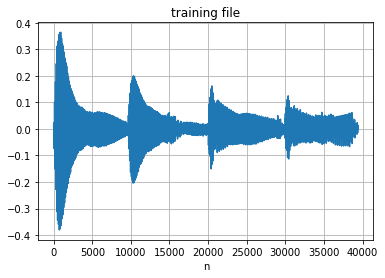

In [7]:
plot(xt)
grid()
title('training file')
xlabel('n')
show()

In [8]:
Audio(xt, rate=sr)

# Preprocessing of Training Data

The time domain Signal $x[n]$ of lnegth $N$ is transformed to the Frequency Domain using the Discrete-time STFT (Short-Time Fourer Transform). 

$ {STFT} \{x[n]\}(m,\omega )\equiv X(m,\omega )=\sum _{n=0 }^{N-1 }x[n]w[n-m]e^{-j\omega n}$

with $w[n]$ being a window funktion ("hann" in this case) $\omega$ being the bin index and $m$ being the frame index. 

The complex valued result of the STFT is then transformed to aplitude/phase data via cartesian to polar conversion, resulting in $\rho(m,\omega)$ and $\phi(m,\omega)$.
To compress the data for the network, this data is then transformed in the following way
- the amplitudes are first log compressed via linear to dB conversion and then clipped between low and high values $\rho_{l}$ and $\rho_{h}$. After that the data is normalized to values between 0 and one.

$$\rho_{db} = min(\rho_h, max(\rho_l, 20 \cdot log_{10}(\rho)))$$
$$\rho_{norm} = \frac{\rho_{db}-\rho_l}{\rho_{h}-\rho_{l}}$$


- the phase data is set to zero if the amplitude data of the corresponding bin is below a defined threshold, $T_{\rho}$
- the phase data is normalized to the intervall $(0, 1)$


this conversion is achieved by the following python code:
```python
@jit(forceobj=True)
def complexToAmpPhase(x, y, setZeroPhase=True):

    # cart2pol
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)/(2*np.pi)

    #normalization
    rho = np.clip(20*np.log10(rho), conf['normLow'], conf["normHigh"])
    normRange = conf['normHigh']-conf["normLow"]
    rho-=conf['normLow']
    rho/=normRange 

    #remove noise from phase for low amp vals
    mask = rho<=0.5
    phi[mask] = 0

    phiNorm = phi+0.5
    return(rhof, phiNorm)
```




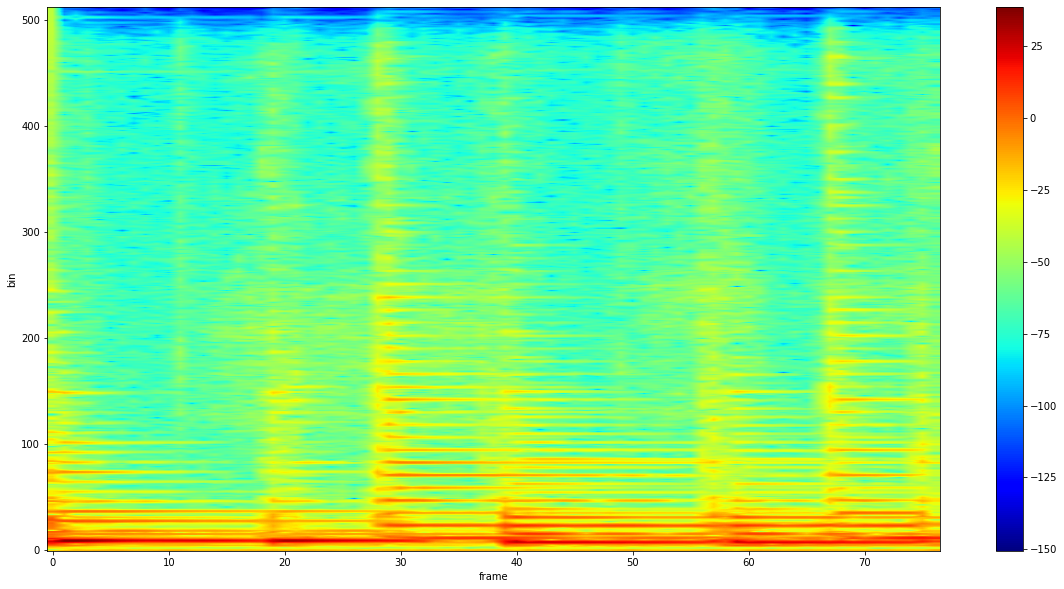

In [9]:
ft = al.getFFT(xt, doPlot=True)

In [10]:
xData,yData = al.stftToXy(ft)

In [11]:
if al.conf['ampOnly']:
    xAmpPhase, yAmpPhase = al.complexSplit(xData,yData)
    finY = yAmpPhase[:,0:xAmpPhase.shape[2]//2]
    finX = xAmpPhase[:,:,0:xAmpPhase.shape[2]//2]
    
else:
    finX,finY = al.complexSplit(xData,yData)

# Buuld and Train Model

Model: "lstmTest_train"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 20, 1026, 1)       0         
_________________________________________________________________
time_distributed (TimeDistri (None, 20, 1017, 10)      110       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 10170)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 20, 128)           5273088   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 200)            

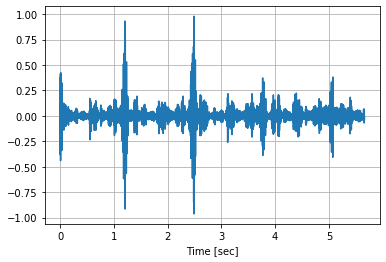

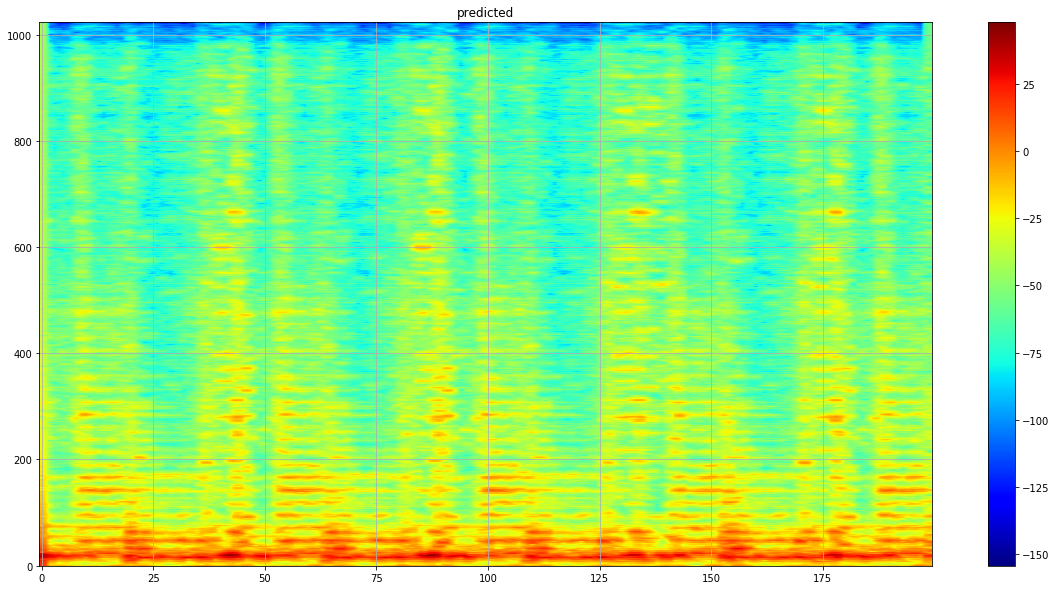

In [12]:
seqLen = al.conf["seqLen"]
nFeatures = finX.shape[2]
nFFT = al.conf["nFFT"]

from numpy.random import seed
seed(42)

config_defaults = {
    'batchSize': 2,
    'learning_rate': 0.0003,
    "dense1": 200,
    "denseMult": 400,
    "numDense":0,
    "numLSTM":2,
    "CNNfilters":10,
    "activationL":'tanh',
    "activationD1":"relu", 
    "activationM":"relu",
    "lstmDim" : 128,
    "useCNN":1,
    "usePool":0,
    'optimizer': 'rmsprop'

}


wandb.init(config=config_defaults)
config = wandb.config

m = keras.models.Sequential(name='lstmTest_train')

m.add(keras.layers.Input(shape=[seqLen, nFeatures]))
if config.useCNN==1: 
    m.add(keras.layers.Reshape([seqLen, nFeatures,1]) )

    m.add(keras.layers.TimeDistributed(keras.layers.Conv1D(config.CNNfilters,10, activation='linear',kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0))))


    if config.usePool:
        m.add(keras.layers.TimeDistributed(keras.layers.AveragePooling1D(2)))
        m.add(keras.layers.TimeDistributed(keras.layers.Dropout(0.1)))


    m.add(keras.layers.TimeDistributed(keras.layers.Flatten()))


for i in range(config.numLSTM):
    m.add(keras.layers.LSTM(config.lstmDim, activation=config.activationL,return_sequences=True, kernel_regularizer=keras.regularizers.l1_l2(l1=0.0000, l2=0)))
m.add(keras.layers.LSTM(config.lstmDim, activation=config.activationL,return_sequences=False, kernel_regularizer=keras.regularizers.l1_l2(l1=0.0000, l2=0)))


m.add(keras.layers.Dense(config.dense1,activation=config.activationD1))
for i in range(config.numDense):

    m.add(keras.layers.Dense(config.denseMult, activation=config.activationM, kernel_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0)))


m.add(keras.layers.Dense(nFeatures, kernel_regularizer=keras.regularizers.l1_l2(l1=0.0, l2=0)))



co = config.optimizer

lr = config.learning_rate

if co=='sgd':
    optimizer = keras.optimizers.SGD(lr=lr, decay=1e-5, momentum=0.9, nesterov=True)
elif co=='rmsprop':
    optimizer = keras.optimizers.RMSprop(lr=lr, decay=1e-5)
elif co=='adam':
    optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif co=='nadam':
    optimizer = keras.optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, clipnorm=1.0)


lossFunc = keras.losses.MeanSquaredLogarithmicError(
reduction="auto", name="mean_squared_logarithmic_error"
)

m.compile(optimizer=optimizer, loss=lossFunc)
m.summary()

hist = m.fit(finX,finY, epochs=200, verbose=0,callbacks=[WandbCallback(), keras.callbacks.TerminateOnNaN()], validation_split=0.3, batch_size=config.batchSize)

frameSize = nFeatures//2
numPreds = 200

n = 0
initialCond = finX[newaxis, n,:]
addSig = np.zeros([numPreds, nFeatures]) + np.random.random([numPreds, nFeatures])
modSig = np.ones([numPreds, nFeatures]) + (np.random.random([numPreds, nFeatures])+0.5)

recording = al.feedbackPredict(m,initialCond, addSig, modSig,numPreds=numPreds, doPlot=False)

if not al.conf['ampOnly']:
    complexPred = al.fromSplit(recording[:,0:frameSize], recording[:,frameSize:])

    timePred = al.getIFFT(complexPred.T)


    figure(figsize=[20,10])
    spTest = librosa.stft(np.clip(timePred, -1,1))
    cm = 'jet'
    myPlt = imshow(20*log10(abs(spTest)), aspect='auto', origin='lower', interpolation='bilinear', cmap=cm)
    colorbar()
    grid()
    title("predicted")


#     wandb.log({"result": myPlt})
else:
    myPlt = imshow(recording, aspect='auto', origin='lower', interpolation='bilinear', cmap='jet')




In [13]:
# hist = m.fit(finX,finY, epochs=100, verbose=1,callbacks=[WandbCallback(), keras.callbacks.TerminateOnNaN()], validation_split=0.3, batch_size=config.batchSize)

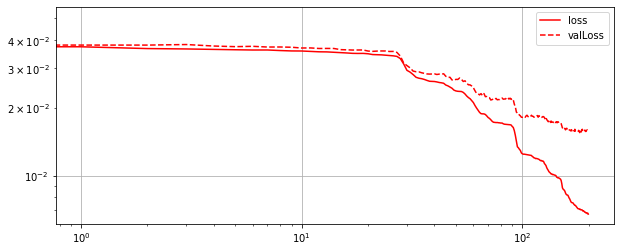

In [14]:
history = hist
plt.figure(figsize=[10,4])
loss = history.history['loss']
valLoss = history.history['val_loss']


plt.loglog(loss, 'r', label='loss')
plt.loglog(valLoss, 'r--', label='valLoss')


plt.legend()
plt.grid()
plt.show()

# Save Model

In [15]:
modelSaveName = 'model_noCNN'+infileName+'.h5'
print("saving model to: ", modelSaveName)
m.save(modelSaveName, overwrite=False)

saving model to:  model_noCNNcello_pizz.h5


[WARNING] model_noCNNcello_pizz.h5 already exists - overwrite? [y/n] n


# Test Model

/opt/conda/lib/python3.6/site-packages/librosa/core/audio.py:161: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn('PySoundFile failed. Trying audioread instead.')


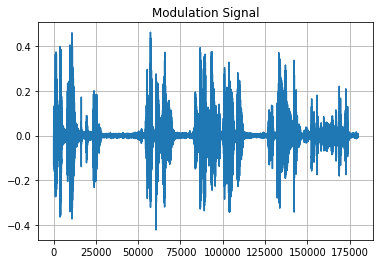

In [16]:
testSigPath  = 'flusser.mp3'
# testSigPath  = 'drumloop.wav'
# testSigPath  = 'cello_pizz.wav'
# testSigPath = 'cello.wav'




addSig,_ = librosa.load(testSigPath, sr=sr, mono=True, duration= 10)
# looped = np.tile(addSig,7)
# addSig = looped
plt.plot(addSig)
plt.title("Modulation Signal")
plt.grid()
show()

In [17]:
Audio(addSig, rate=sr)

In [18]:
addSigSpec = al.getFFT(addSig)

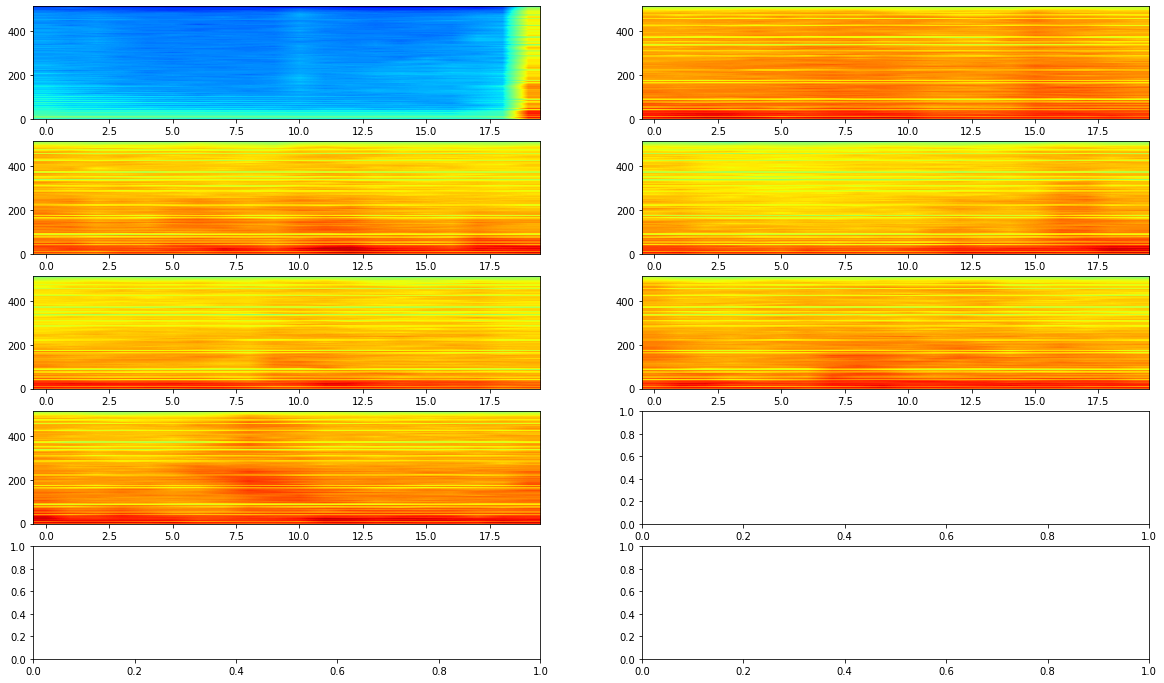

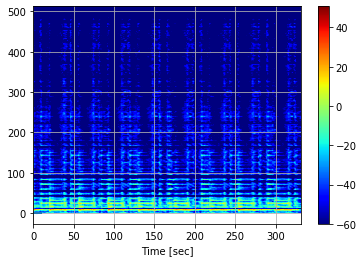

In [30]:
numPreds = 7750
fbAtten = 0.7
addSigAmp = 1.0

useNoise = False

if al.conf['ampOnly']:
    

    addSigR = addSigSpec.real
    addSigI = addSigSpec.imag
    addSigAmp,addSigPhase = al.cart2pol(addSigR,addSigI)


    addSigAmp.shape

    model = m
    seqLen = al.conf["seqLen"]
    nFeatures = finX.shape[2]
    nFFT = al.conf["nFFT"]
    frameSize = nFeatures//2

    #         n = randint(0,finX.shape[0])
    n = 0
    initialCond = finX[newaxis, n,:]


    
    modSig = np.zeros([numPreds, nFeatures]) #+ (np.random.random([numPreds, nFeatures])+0.5)*0.

    rec = al.feedbackPredict(model, initialCond, addSigAmp.T*addSigAmp, modSig,numPreds=numPreds , fbAtten=fbAtten)

    imshow(rec, aspect='auto', origin='lower', cmap='jet')
    colorbar()

    comb = al.fromSplit(rec, addSigPhase[:,:numPreds].T*0)

    result = al.getIFFT(comb.T)



else:
    _x,addSigy = al.stftToXy(addSigSpec)
    _,addSigSplit = al.complexSplit(_x,addSigy) 
    
    
    model = m
    seqLen = al.conf["seqLen"]
    nFeatures = finX.shape[2]
    nFFT = al.conf["nFFT"]
    frameSize = nFeatures//2
    numPreds = min(numPreds,addSigSplit.shape[0])

    n = 0
    
    if addSigSplit.shape[0]>=seqLen:
        initialCond = addSigSplit[newaxis, n:seqLen,:]
    else:
        initialCond = finX[newaxis, n,:]
    
    initialCond = random.random([1, seqLen,nFeatures])
    initialCond = finX[newaxis, n,:]

    modSig = np.ones([numPreds, nFeatures]) 
    
    if useNoise:
        addSig = np.zeros([numPreds, nFeatures]) + np.random.random([numPreds, nFeatures])
        modSig = np.ones([numPreds, nFeatures]) + (np.random.random([numPreds, nFeatures])+0.5)


    rec = al.feedbackPredict(model, initialCond, addSigSplit*addSigAmp, modSig*1,numPreds=numPreds, fbAtten=fbAtten, doPlot=True )


    
    
    complexPred = al.fromSplit(rec[:,0:frameSize], rec[:,frameSize:]+np.random.random(rec[:,frameSize:].shape)*0.0)
    imshow(20*log10(clip(abs(complexPred.T),1e-8,1e9 )), aspect='auto', origin='lower', interpolation='bilinear', cmap='jet', vmin=-60)
    colorbar()
    

    result = al.getIFFT(complexPred.T)

    

    

In [31]:
Audio(result, rate=sr)

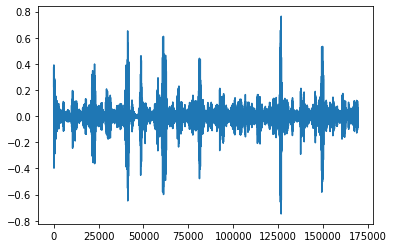

In [29]:
plot(result)

In [23]:
librosa.output.write_wav('celloTrained_speech.wav', result, sr=sr)

# Other Results

In [24]:
xt,r = librosa.load('interestingSamples/celloTrained_cello.wav')
Audio(xt,rate=r)

In [32]:
xt,r = librosa.load('interestingSamples/speechTrained_DrumAdded4.wav')
Audio(xt,rate=r)

In [26]:
xt,r = librosa.load('interestingSamples/celloTrained_DrumAdded.wav')
Audio(xt,rate=r)

In [34]:
xt,r = librosa.load('interestingSamples/06112020185204.wav')
Audio(xt,rate=r)